In [1]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
%matplotlib inline

from processing import Stationarizer, Normalizer
#from tuner import LSTMLayerHyperparams, ModelHyperparams
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

2024-08-04 15:49:22.652264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("data/YF_TSLA.csv")["Adj Close"].to_numpy().reshape(-1, 1)

In [3]:
normer = Normalizer()
normer.fit(data)

In [4]:
train_idx = int(0.7 * np.shape(data)[0])
val_idx = int(0.85 * np.shape(data)[0])

train_data = data[:train_idx]
val_data = data[train_idx:val_idx]
non_test_data = data[:val_idx]
test_data = data[val_idx:]

In [5]:
train_data = normer.transform(train_data)
val_data = normer.transform(val_data)

In [6]:
#train_data

In [7]:
#joblib.dump(normer, "TSLA_normer.gz")

In [8]:
train_ds = timeseries_dataset_from_array(
    train_data[:-20],
    train_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=True
)
val_ds = timeseries_dataset_from_array(
    val_data[:-20],
    val_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=True
)

for batch in train_ds.take(1):
    inputs, targets = batch
    print(inputs[0])
    print(targets[0])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

tf.Tensor(
[[-0.55663938]
 [-0.55707731]
 [-0.5582473 ]
 [-0.5663523 ]
 [-0.55863294]
 [-0.55928658]
 [-0.5573453 ]
 [-0.55776361]
 [-0.56178997]
 [-0.55767864]
 [-0.55516218]
 [-0.57084925]
 [-0.57321538]
 [-0.57411085]
 [-0.57657503]
 [-0.57605212]
 [-0.57321538]
 [-0.57279707]
 [-0.56505811]
 [-0.56131283]], shape=(20, 1), dtype=float64)
tf.Tensor([-0.56488817], shape=(1,), dtype=float64)
Input shape: (64, 20, 1)
Target shape: (64, 1)


2024-08-04 15:49:27.742496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
#train_ds.save("data/TSLA_ds/train")
#val_ds.save("data/TSLA_ds/val")

In [10]:
#tuner = get_tuner()
#tuner.search(train_ds, epochs=50, validation_data=val_ds)

In [ ]:
tuner = get_tuner(500, 1)
tuner.search(train_ds, epochs=60, validation_data=val_ds)

Trial 2 Complete [00h 00m 36s]
val_mse: 0.7032281160354614

Best val_mse So Far: 0.7032281160354614
Total elapsed time: 00h 01m 12s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
True              |True              |selu
leaky_relu        |silu              |activation
0.51491           |0.4318            |dropout_0
0.16561           |0.10404           |recurrent_dropout_0
0.33568           |0.34169           |dropout_1
0.21076           |0.059712          |recurrent_dropout_1
glorot_normal     |orthogonal        |kernel_initializer_2
0.003255          |0.0021476         |lr

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1080 - mse: 0.1080 - val_loss: 1.8186 - val_mse: 1.8186
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 1.6532 - val_mse: 1.6532
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 1.6690 - val_mse: 1.6690
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━

In [ ]:
model = build_spec_model(
    2, 
    [32, 32], 
    ["tanh", "tanh"], 
    ["sigmoid", "sigmoid"], 
    [0.2, 0.2], 
    [0.0, 0.0],
    0.001
)
history = model.fit(
    train_ds,
    batch_size=64,
    epochs=100,
    validation_data=val_ds
)

In [10]:
trials = list()
for n in range(100):
    path = f"tuning/stock_predictor_2024-08-04 08:10:52.540990/trial_{n:03d}/trial.json"
    with open(path, mode="r") as f:
        trial = json.load(f)
        trials.append(trial)

#trials[0]

In [11]:
def sort(array):
    """Sort the array by using quicksort."""

    less = []
    equal = []
    greater = []

    if len(array) > 1:
        pivot = array[0]["score"]
        for x in array:
            if x["score"] < pivot:
                less.append(x)
            elif x["score"] == pivot:
                equal.append(x)
            elif x["score"] > pivot:
                greater.append(x)
        return sort(less)+equal+sort(greater)
    else:
        return array

In [12]:
sorted_trials = sort(trials)
tmp = copy.deepcopy(sorted_trials)
rmse_trials = list()
for trial in tmp:
    trial.update({"score" : np.sqrt(trial["score"])})
    rmse_trials.append(trial)


In [13]:
bins = np.linspace(min([x["score"] for x in rmse_trials]), max([x["score"] for x in rmse_trials]), 25)

In [14]:
counts = [[cutoff, 0] for cutoff in bins]
t = 0
c = 0
while t < len(rmse_trials) and c < len(counts):
    if rmse_trials[t]["score"] <= counts[c][0]:
        counts[c][1] += 1
        t += 1
    else:
        c += 1

np.sum([el[1] for el in counts])

100

Text(0.5, 1.0, 'Score distribution')

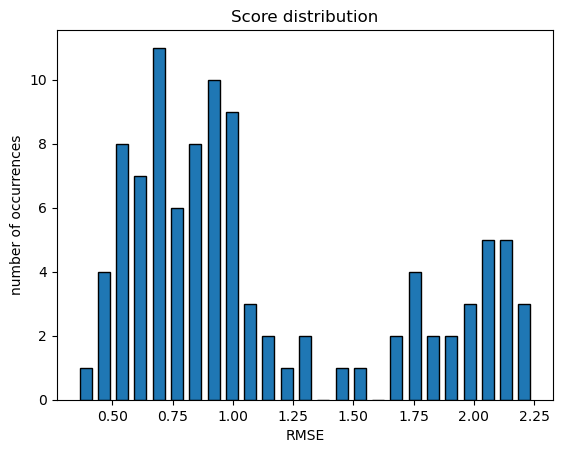

In [16]:
scx = list()
heights = list()
for el in counts:
    scx.append(el[0])
    heights.append(el[1])

plt.bar(scx, heights, edgecolor="black", width=0.05)
plt.xlabel("RMSE")
plt.ylabel("number of occurrences")
plt.title("Score distribution")

In [21]:
reg = LinearRegression()
rmse_scores = np.array([trial["score"] for trial in rmse_trials])

In [17]:
num_layers = [trial["hyperparameters"]["values"]["num_layers"] for trial in rmse_trials]
rmse_scores = np.array([trial["score"] for trial in rmse_trials])
plt.scatter(num_layers, rmse_scores)
plt.xlabel("number of LSTM layers")
plt.ylabel("RMSE")


reg.fit(np.array(num_layers).reshape((-1, 1)), np.array(rmse_scores).reshape((-1, 1)))
x = np.linspace(min(num_layers), max(num_layers), 100)
plt.plot(x, np.array(reg.coef_ * x + reg.intercept_).reshape((-1, 1)))

KeyError: 'num_layers'

Text(0, 0.5, 'RMSE')

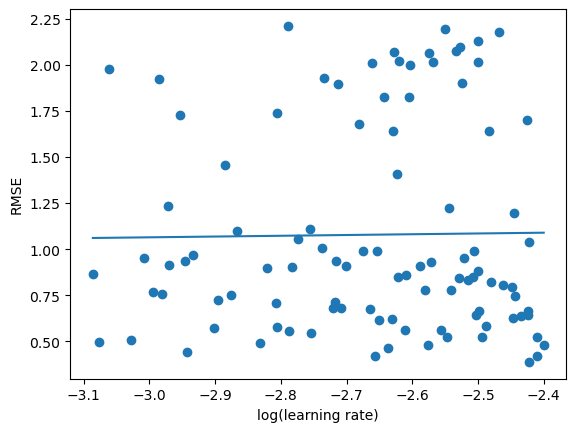

In [22]:
log_lrs = np.array([np.log10(trial["hyperparameters"]["values"]["lr"]) for trial in rmse_trials])
reg.fit(log_lrs.reshape((-1, 1)), rmse_scores.reshape((-1, 1)))
x = np.linspace(min(log_lrs), max(log_lrs), 100)
y = reg.coef_ * x + reg.intercept_
plt.scatter(log_lrs, rmse_scores.reshape((-1, 1)))
plt.plot(x, y.reshape((-1, 1)))
plt.xlabel("log(learning rate)")
plt.ylabel("RMSE")

In [24]:
df = pd.DataFrame([trial["hyperparameters"]["values"] for trial in rmse_trials])
df["trial id"] = [trial["trial_id"] for trial in rmse_trials]
df["rmse"] = [trial["score"] for trial in rmse_trials]
df[:15]

,activation,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_2,lr,trial id,rmse
0,selu,0.45,0.05,0.20,0.10,glorot_normal,0.003781,042,0.388760
1,selu,0.25,0.05,0.30,0.20,he_uniform,0.003890,095,0.418419
2,relu,0.25,0.10,0.25,0.20,he_uniform,0.002208,068,0.421811
3,relu,0.25,0.25,0.35,0.20,he_uniform,0.001143,014,0.441298
4,leaky_relu,0.45,0.15,0.45,0.00,he_uniform,0.002305,006,0.462220
5,selu,0.45,0.20,0.35,0.15,he_uniform,0.002657,044,0.477958
6,selu,0.25,0.05,0.20,0.20,he_normal,0.003983,031,0.479455
7,relu,0.40,0.10,0.35,0.15,glorot_normal,0.001474,025,0.492567
8,selu,0.20,0.05,0.25,0.05,glorot_uniform,0.000839,087,0.494173
9,selu,0.45,0.20,0.45,0.05,he_uniform,0.000939,059,0.509677


In [ ]:
df.to_pickle("tuning/dataframe.pkl")